In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
from random import seed
from random import randint

In [ ]:
# Function to load image data and labels for a specific fruit and type (Train/Test)
def load_data(manhole, tipo):
    # Initialize lists to store images and labels
    label = []
    arr = []
    # Fetch file paths for the given fruit and type using glob
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        # Read the image, convert it to RGB, and add it to the list
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        # Add the corresponding label to the label list
        label.append(manhole)
    return arr, label

In [ ]:
# Function to load the entire training or test dataset
def whole_train_data(tipo):
    # Load data and labels for each category (Closed, Open, Road)
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    # Concatenate data and labels for all categories
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

In [ ]:
# Load the entire training dataset
data_train, labels_train = whole_train_data('Train')
# Load the entire test dataset
data_test, labels_test = whole_train_data('Test')

<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
# Preprocessing function to convert images to grayscale and resize them
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert each image to grayscale
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [ ]:
# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))

In [ ]:
# Expand dimensions to represent single-channel (grayscale) images
data_train_p = np.expand_dims(data_train_p, axis=-1)
data_test_p = np.expand_dims(data_test_p, axis=-1)

In [ ]:
# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 output classes (Closed, Open, Road)
    return model

In [ ]:
# Define the input shape for the model
input_shape = (72, 72, 1)
# Create the CNN model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Encode the training and test labels using LabelEncoder and one-hot encoding
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)

In [ ]:
# Train the model
model.fit(data_train_p, labels_train_one_hot, epochs=20, batch_size=32)

Epoch 1/20
117/117 [==============================] - 19s 151ms/step - loss: 0.8551 - accuracy: 0.5930
Epoch 2/20
117/117 [==============================] - 18s 151ms/step - loss: 0.6484 - accuracy: 0.7214
Epoch 3/20
117/117 [==============================] - 19s 159ms/step - loss: 0.5474 - accuracy: 0.7550
Epoch 4/20
117/117 [==============================] - 17s 149ms/step - loss: 0.4547 - accuracy: 0.8032
Epoch 5/20
117/117 [==============================] - 18s 152ms/step - loss: 0.3708 - accuracy: 0.8460
Epoch 6/20
117/117 [==============================] - 18s 157ms/step - loss: 0.2809 - accuracy: 0.8880
Epoch 7/20
117/117 [==============================] - 18s 150ms/step - loss: 0.2346 - accuracy: 0.9071
Epoch 8/20
117/117 [==============================] - 19s 159ms/step - loss: 0.1821 - accuracy: 0.9306
Epoch 9/20
117/117 [==============================] - 22s 185ms/step - loss: 0.1160 - accuracy: 0.9591
Epoch 10/20
117/117 [==============================] - 18s 157ms/step - l

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc*100, "%")

32/32 [==============================] - 2s 51ms/step - loss: 0.4244 - accuracy: 0.8694
Test Loss: 0.42443642020225525
Test Accuracy: 86.93917989730835 %


In [ ]:
# Predict the labels for the test data
y_pred = model.predict(data_test_p)
# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
labels_test_encoded = label_encoder.transform(labels_test)

32/32 [==============================] - 1s 40ms/step


In [ ]:
# Calculate the F1 score
f1 = f1_score(labels_test_encoded, y_pred_labels, average='weighted')
print('F1 Score:', f1)

F1 Score: 0.8684215173115266


In [ ]:
# Create a classification report to show precision, recall, and F1 score for each class
class_names = label_encoder.classes_
print('Classification Report:')
print(classification_report(labels_test_encoded, y_pred_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      Closed       0.83      0.88      0.86       380
        Open       0.89      0.93      0.91       363
        Road       0.89      0.77      0.82       260

    accuracy                           0.87      1003
   macro avg       0.87      0.86      0.86      1003
weighted avg       0.87      0.87      0.87      1003



In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test_encoded, y_pred_labels)

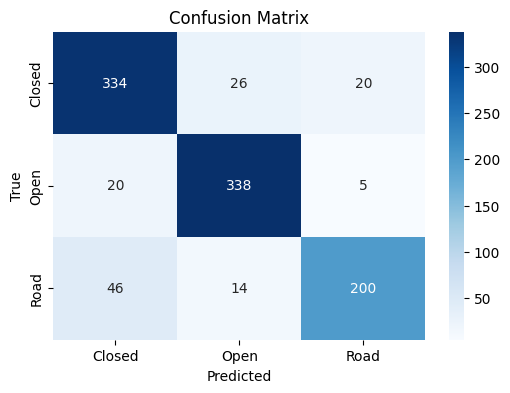

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

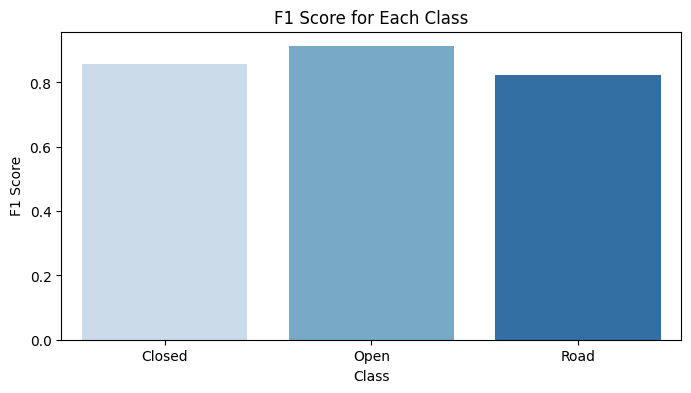

In [ ]:
# Create a bar plot to show the F1 score for each class
f1_scores = [f1_score(labels_test_encoded, y_pred_labels, average=None)]
f1_scores.sort(reverse=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores[0], palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()

In [ ]:
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

1/1 [==============================] - 0s 16ms/step


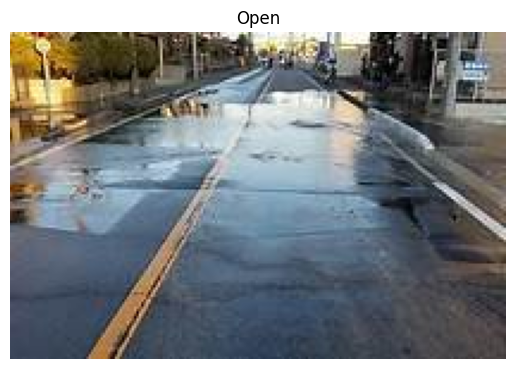

1/1 [==============================] - 0s 61ms/step


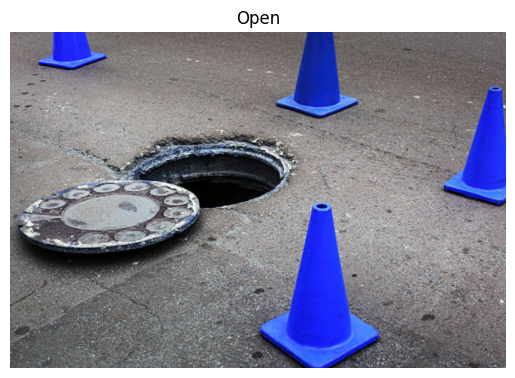

In [ ]:
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_labels = model.predict(np.expand_dims(data_test_p[x_], axis=0))
predicted_label = np.argmax(predicted_labels)
predicted_manhole = label_encoder.inverse_transform([predicted_label])[0]
showImg(data_test[x_], predicted_manhole)
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-08-15 142217.png"
img = cv2.imread(image_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
predicted_labels = model.predict(img_input)
predicted_label = np.argmax(predicted_labels)
predicted_manhole = label_encoder.inverse_transform([predicted_label])[0]
showImg(img, predicted_manhole)

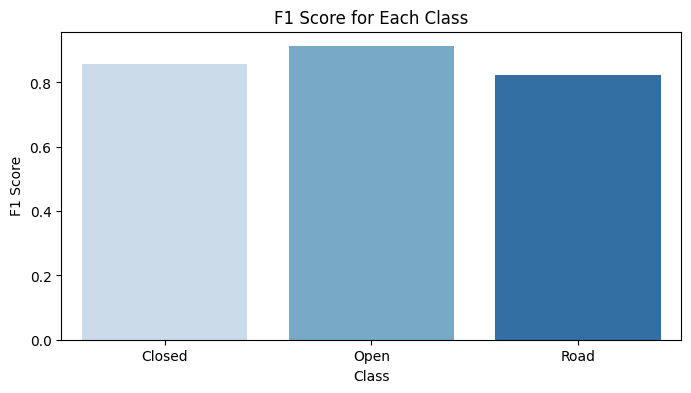

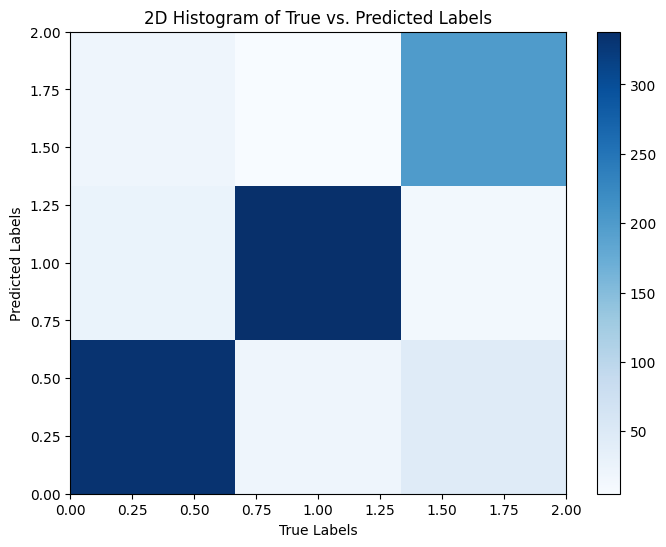

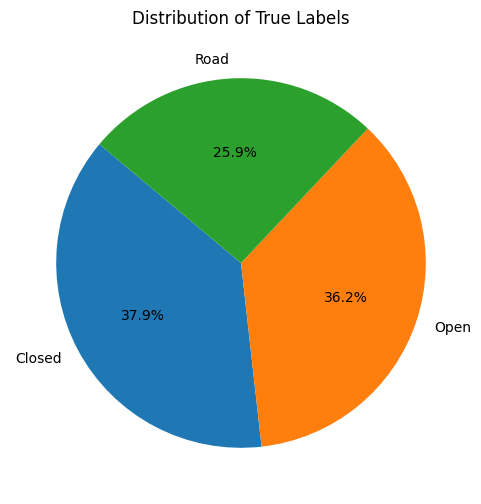

In [ ]:
# Create a bar plot to show the F1 score for each class
f1_scores = [f1_score(labels_test_encoded, y_pred_labels, average=None)]
f1_scores.sort(reverse=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores[0], palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()

# 2D Histogram
plt.figure(figsize=(8, 6))
plt.hist2d(labels_test_encoded, y_pred_labels, bins=(3, 3), cmap='Blues')
plt.colorbar()
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('2D Histogram of True vs. Predicted Labels')
plt.show()

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(labels_test_encoded), labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of True Labels')
plt.show()

# Assuming you have a DataFrame 'df' with data to correlate
# Correlation Heatmap
# corr_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt


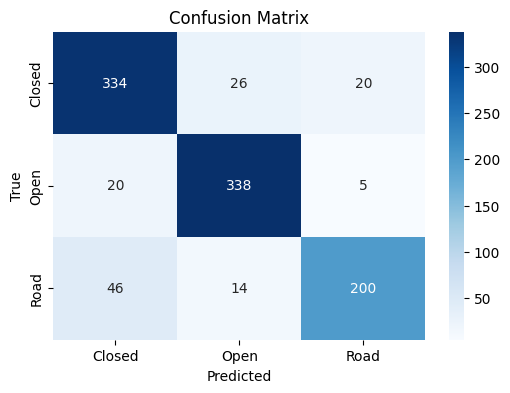

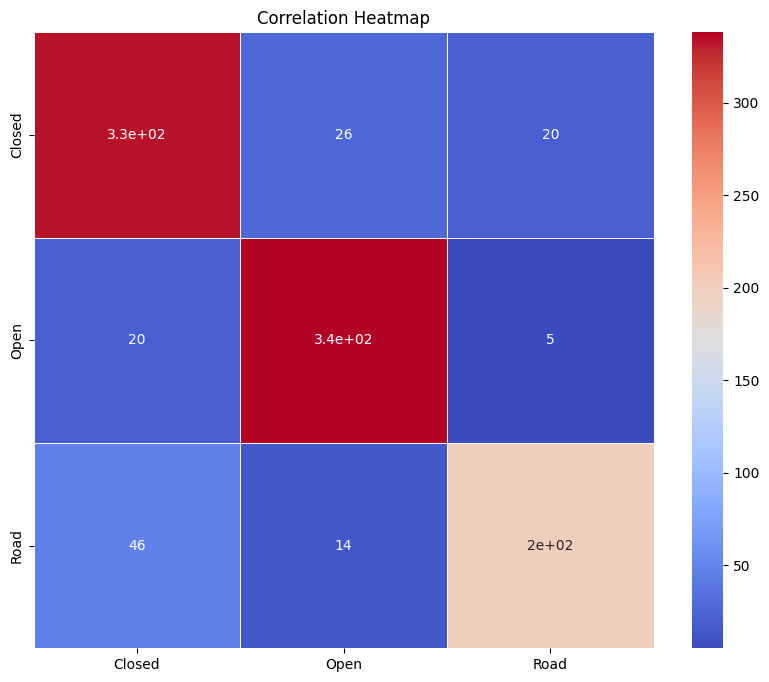

In [ ]:
# ... (Your existing code) ...

# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test_encoded, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Correlation Heatmap
corr_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


*****Results

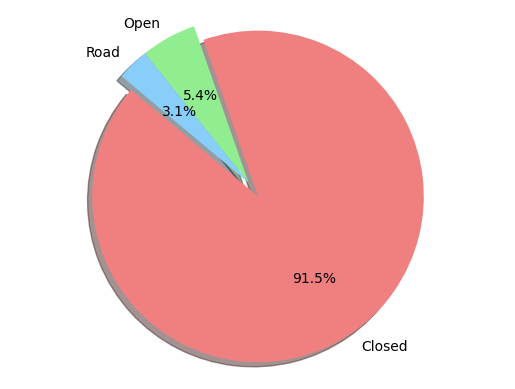

In [ ]:
import matplotlib.pyplot as plt

# Example data
labels = ['Closed', 'Open', 'Road']
sizes = [321, 19, 11]
colors = ['lightcoral', 'lightgreen', 'lightskyblue']
explode = (0.1, 0, 0)  # Explode the 1st slice (i.e., 'Closed')

# Create a pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()


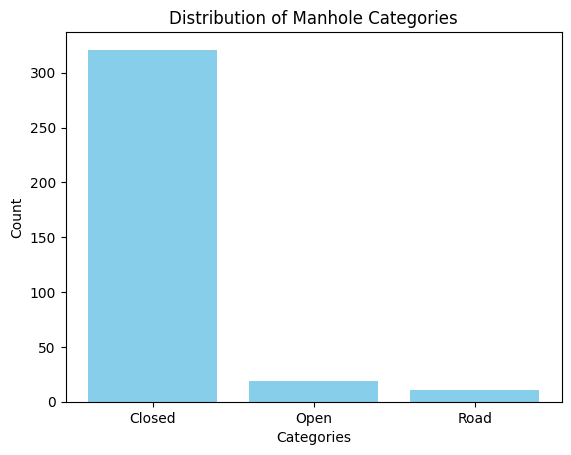

In [ ]:
import matplotlib.pyplot as plt

# Example data
categories = ['Closed', 'Open', 'Road']
counts = [321, 19, 11]

# Create a bar chart
plt.bar(categories, counts, color='skyblue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Manhole Categories')

# Display the bar chart
plt.show()


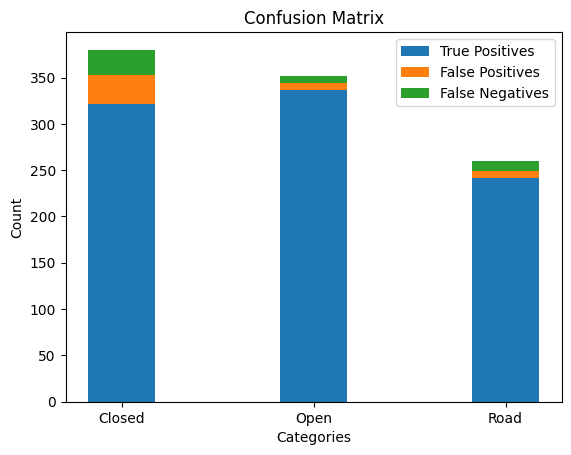

In [ ]:
import matplotlib.pyplot as plt

# Example data for confusion matrix
categories = ['Closed', 'Open', 'Road']
true_positives = [321, 336, 242]
false_positives = [32, 8, 7]
false_negatives = [27, 8, 11]

# Create a stacked bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(categories))

plt.bar(index, true_positives, bar_width, label='True Positives')
plt.bar(index, false_positives, bar_width, label='False Positives', bottom=true_positives)
plt.bar(index, false_negatives, bar_width, label='False Negatives', bottom=[i + j for i, j in zip(true_positives, false_positives)])

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Confusion Matrix')
plt.xticks(index, categories)
plt.legend()

# Display the stacked bar chart
plt.show()


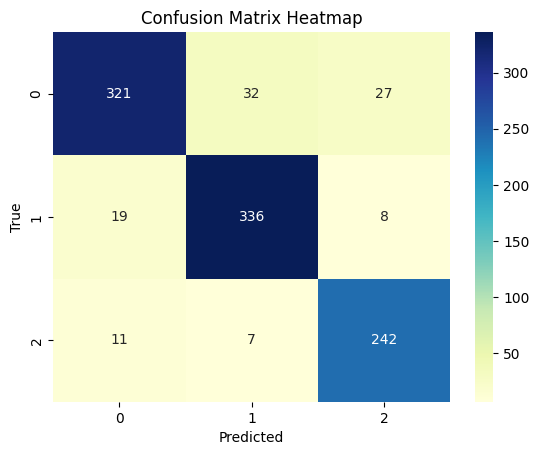

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Example data for a heatmap
data = [
    [321, 32, 27],
    [19, 336, 8],
    [11, 7, 242]
]

# Create a heatmap using Seaborn
sns.heatmap(data, annot=True, cmap='YlGnBu', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


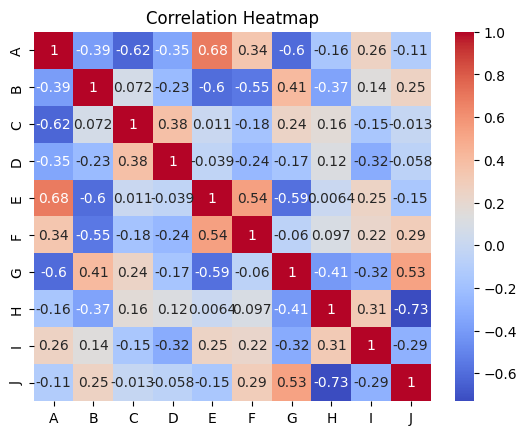

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data for a correlation heatmap
data = pd.DataFrame(data=np.random.rand(10, 10), columns=list('ABCDEFGHIJ'))

# Create a correlation heatmap using Seaborn
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


<ipython-input-41-bfa8584b5601>:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



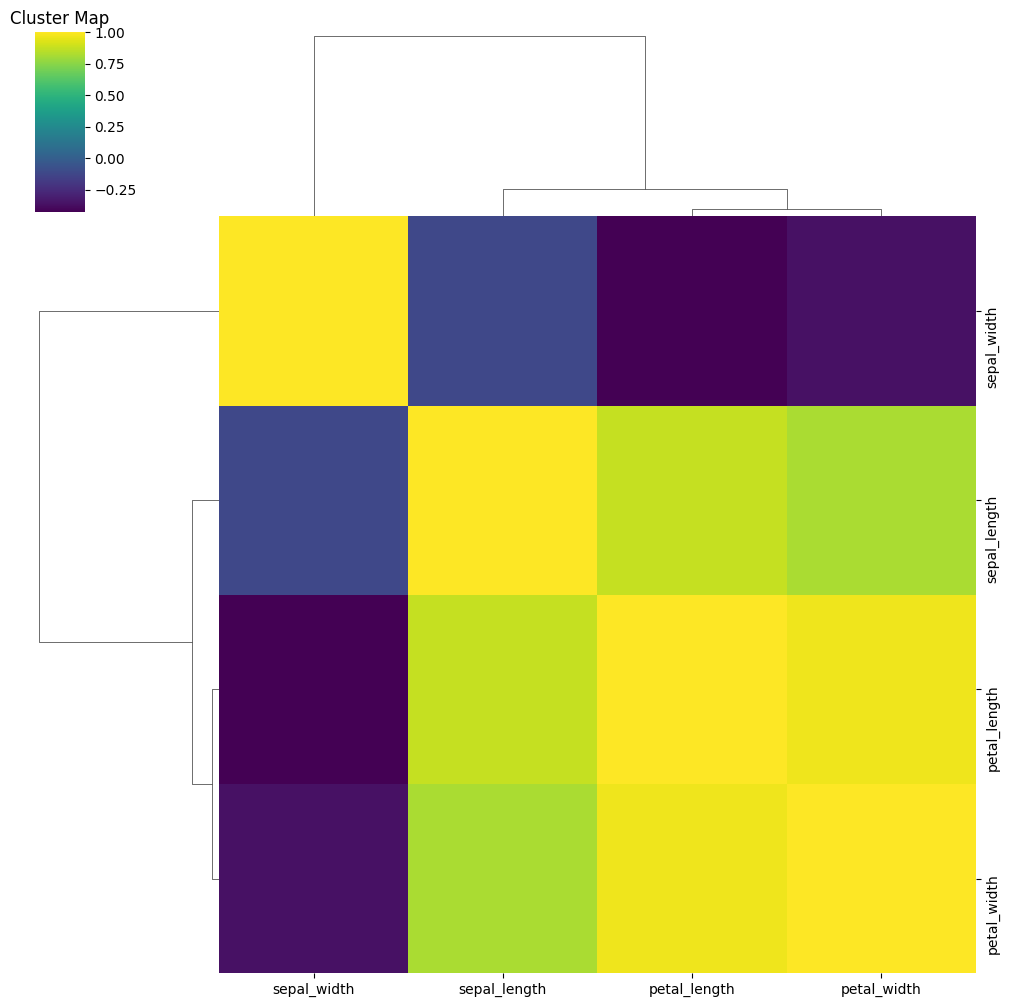

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data for a cluster map
data = sns.load_dataset('iris')

# Create a cluster map using Seaborn
sns.clustermap(data.corr(), cmap='viridis')
plt.title('Cluster Map')
plt.show()


In [ ]:
import plotly.graph_objects as go

# Example data for a heatmap
z = [
    [321, 32, 27],
    [19, 336, 8],
    [11, 7, 242]
]

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(z=z, colorscale='Viridis'))
fig.update_layout(title='Confusion Matrix Heatmap')
fig.show()


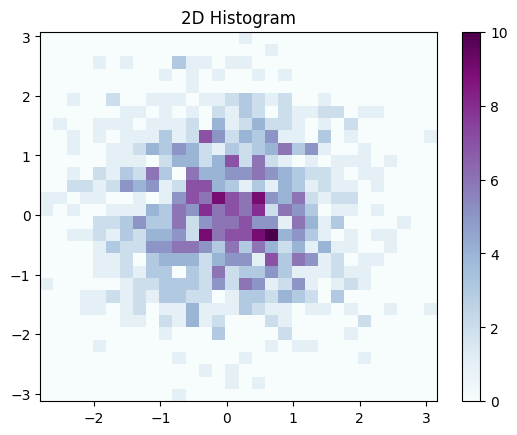

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for a 2D histogram
x = np.random.randn(1000)
y = np.random.randn(1000)

# Create a 2D histogram using Matplotlib
plt.hist2d(x, y, bins=(30, 30), cmap=plt.cm.BuPu)
plt.colorbar()
plt.title('2D Histogram')
plt.show()
